In [73]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import function_library_assignment_1 as fnc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #filtering FutureWarnings - we don't need to worry about them in this case
#(This is run using Python 3.9)

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading data

In [74]:
S_base_3ph = 100
gen_data = fnc.read_data('gen_data')
demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_costs = fnc.read_data('gen_costs')
line_data = fnc.read_data('line_data')
branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data')
all_bid_prices = fnc.read_data('all_bid_prices')

GC = len(gen_data.index)
GW = len(wind_data.columns)
G = GC + GW
D = len(load_distribution.index)
N = 24 # number of buses

WF_NODES = [2, 4, 6, 15, 20, 22] # zero-indexed

t = 17 #hour


Set up demand array for the hour

In [75]:
load = np.zeros(N)

#Saving the load for each bus in a numpy array accounting for the system load distribution
for n in load_distribution['Node'].unique():
    load[n-1] = load_distribution.loc[load_distribution['Node'] == n, r'% of system load'] / 100 * demand[t] #per-unitized load - remember that the data is not 0-indexed but the arrays are
load


array([100.719 ,  90.117 , 166.9815,  68.913 ,  66.2625, 127.224 ,
       116.622 , 159.03  , 161.6805, 180.234 ,   0.    ,   0.    ,
       246.4965, 180.234 , 294.2055,  92.7675,   0.    , 310.1085,
       169.632 , 119.2725,   0.    ,   0.    ,   0.    ,   0.    ])

Setup bid prices for loads

In [76]:
bid_prices = np.zeros(D)

for n in range(D):
    bid_prices[n] = all_bid_prices.loc[all_bid_prices['Load #'] == (n + 1), f't{t+1}']

print(load)

print(bid_prices)

[100.719   90.117  166.9815  68.913   66.2625 127.224  116.622  159.03
 161.6805 180.234    0.       0.     246.4965 180.234  294.2055  92.7675
   0.     310.1085 169.632  119.2725   0.       0.       0.       0.    ]
[21.  9. 12. 15.  6. 22. 19. 23. 29. 14. 22. 20. 11.  6. 26.  9. 13.]


## Setup Gurobi model

In [77]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

#============= Variables =============
p_G = m.addVars(G, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: wind farms can be curtailed AND P_min from the system should be disregarded to avoid having a mixed integer program
p_D = m.addVars(D, lb=0, ub=gb.GRB.INFINITY, name="P_D") #Note: demands are elastic

#============= Objective function =============
# Set objective function (social welfare) - note that production cost of wind farms is assumed to be zero
obj = gb.quicksum(bid_prices[d] * p_D[d] for d in range(D)) - gb.quicksum(gen_costs['C ($/MWh)'][k] * p_G[k] for k in range(GC))
m.setObjective(obj, direction)

#============= Balance equation =============
m.addConstr(gb.quicksum(p_D[d] for d in range(D)) - gb.quicksum(p_G[g] for g in range(G)) == 0)

#============= Generator limits ============
m.addConstrs(p_G[g] <= (gen_data['P max MW'].iloc[g]) for g in range(GC)) #conventinal generator upper limits

#Maximum wind power is the per-unitized output of the non-curtailed wind farm in the hour t
m.addConstrs(p_G[GC + g] <= wind_data.iloc[t, g] for g in range(GW)) #wind farm generator upper limits

#============= Demand limits ===============
m.addConstrs(p_D[d] <= load[load != 0][d] for d in range(D)) #demand limits

#============= Display and run model =============
m.update()
m.display()
m.optimize()
print(m.Pi)

Maximize
-13.32 P_G[0] + -13.32 P_G[1] + -20.7 P_G[2] + -20.93 P_G[3] + -26.11 P_G[4] +
-10.52 P_G[5] + -10.52 P_G[6] + -6.02 P_G[7] + -5.47 P_G[8] + -10.52 P_G[10] +
-10.89 P_G[11] + 21.0 P_D[0] + 9.0 P_D[1] + 12.0 P_D[2] + 15.0 P_D[3] + 6.0 P_D[4]
+ 22.0 P_D[5] + 19.0 P_D[6] + 23.0 P_D[7] + 29.0 P_D[8] + 14.0 P_D[9] + 22.0 P_D[10]
+ 20.0 P_D[11] + 11.0 P_D[12] + 6.0 P_D[13] + 26.0 P_D[14] + 9.0 P_D[15] + 13.0 P_D[16]
Subject To
R0: -1.0 P_G[0] + -1.0 P_G[1] + -1.0 P_G[2] + -1.0 P_G[3] + -1.0 P_G[4] + -1.0 P_G[5] +
-1.0 P_G[6] + -1.0 P_G[7] + -1.0 P_G[8] + -1.0 P_G[9] + -1.0 P_G[10] + -1.0 P_G[11] +
-1.0 P_G[12] + -1.0 P_G[13] + -1.0 P_G[14] + -1.0 P_G[15] + -1.0 P_G[16] + -1.0 P_G[17]
+ P_D[0] + P_D[1] + P_D[2] + P_D[3] + P_D[4] + P_D[5] + P_D[6] + P_D[7] + P_D[8] +
 P_D[9] + P_D[10] + P_D[11] + P_D[12] + P_D[13] + P_D[14] + P_D[15] + P_D[16] = 0
  R1: P_G[0] <= 152
  R2: P_G[1] <= 152
  R3: P_G[2] <= 350
  R4: P_G[3] <= 591
  R5: P_G[4] <= 60
  R6: P_G[5] <= 155
  R7: P_G[6] <= 155


## Analyze results

In [78]:
#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {}
    generator_outputs = pd.DataFrame(data=np.zeros(G), columns=['p_G'])
    generator_outputs['Node'] = 0 #initialize
    generator_outputs['Dispatched Percentage'] = 0
    generator_outputs['Type'] = 'Conventional'

    load_results = pd.DataFrame(data=np.zeros(D), columns=['p_D'])
    load_results['Node'] = load_distribution['Node'].values
    load_results['Maximum Demand'] = load[load != 0]

    constraints = m.getConstrs()
    # The constraint dual value of the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m.objVal)

    for i in range(G):
        print(p_G[i].VarName + ": %.2f MW" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x

        if i < GC:
            generator_outputs.loc[generator_outputs.index == i, 'Node'] = gen_data.loc[gen_data.index == i, 'Node'].values #save node
            gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
            generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i].x / gen_limit) * 100
        else:
            generator_outputs.loc[generator_outputs.index == i, 'Node'] = WF_NODES[i - GC] + 1 #save node (from zero-indexed to 1-indexed)
            wind_limit = wind_data.iloc[t, i - GC]
            generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i].x / wind_limit) * 100
            generator_outputs.loc[generator_outputs.index == i, 'Type'] = 'Wind'

    for i in range(D):
        print(p_D[i].VarName + ": %.2f MW" % p_D[i].x)
        load_results.loc[load_results.index == i, 'p_D'] = p_D[i].x

    for k in range(len(constraints)):
        print('Dual value {0}: '.format(k+1), dual_values[k])

    sum_gen = sum(p_G[n].x for n in range(G))
    sum_load = sum(p_D[n].x for n in range(D))
    print("\nTotal load: %.1f MWh" % sum_load)
    print("Total generation: %.1f MWh" % sum_gen)

    results['gen'] = generator_outputs.copy(deep=True)
    results['demand'] = load_results.copy(deep=True)

    print("Lambda: %.2f $/MWh" % m.Pi[0])

else:
    print("Optimization was not successful.")     

-----------------------------------------------
Optimal objective value: 30418.74 $
P_G[0]: 0.00 MW
P_G[1]: 0.00 MW
P_G[2]: 0.00 MW
P_G[3]: 0.00 MW
P_G[4]: 0.00 MW
P_G[5]: 155.00 MW
P_G[6]: 155.00 MW
P_G[7]: 400.00 MW
P_G[8]: 400.00 MW
P_G[9]: 300.00 MW
P_G[10]: 310.00 MW
P_G[11]: 126.46 MW
P_G[12]: 64.11 MW
P_G[13]: 51.01 MW
P_G[14]: 78.37 MW
P_G[15]: 65.47 MW
P_G[16]: 66.54 MW
P_G[17]: 59.77 MW
P_D[0]: 100.72 MW
P_D[1]: 0.00 MW
P_D[2]: 166.98 MW
P_D[3]: 68.91 MW
P_D[4]: 0.00 MW
P_D[5]: 127.22 MW
P_D[6]: 116.62 MW
P_D[7]: 159.03 MW
P_D[8]: 161.68 MW
P_D[9]: 180.23 MW
P_D[10]: 246.50 MW
P_D[11]: 180.23 MW
P_D[12]: 294.21 MW
P_D[13]: 0.00 MW
P_D[14]: 310.11 MW
P_D[15]: 0.00 MW
P_D[16]: 119.27 MW
Dual value 1:  10.89
Dual value 2:  0.0
Dual value 3:  0.0
Dual value 4:  0.0
Dual value 5:  0.0
Dual value 6:  0.0
Dual value 7:  0.370000000000001
Dual value 8:  0.370000000000001
Dual value 9:  4.870000000000001
Dual value 10:  5.420000000000001
Dual value 11:  10.89
Dual value 12:  0.3700000

## Visualization

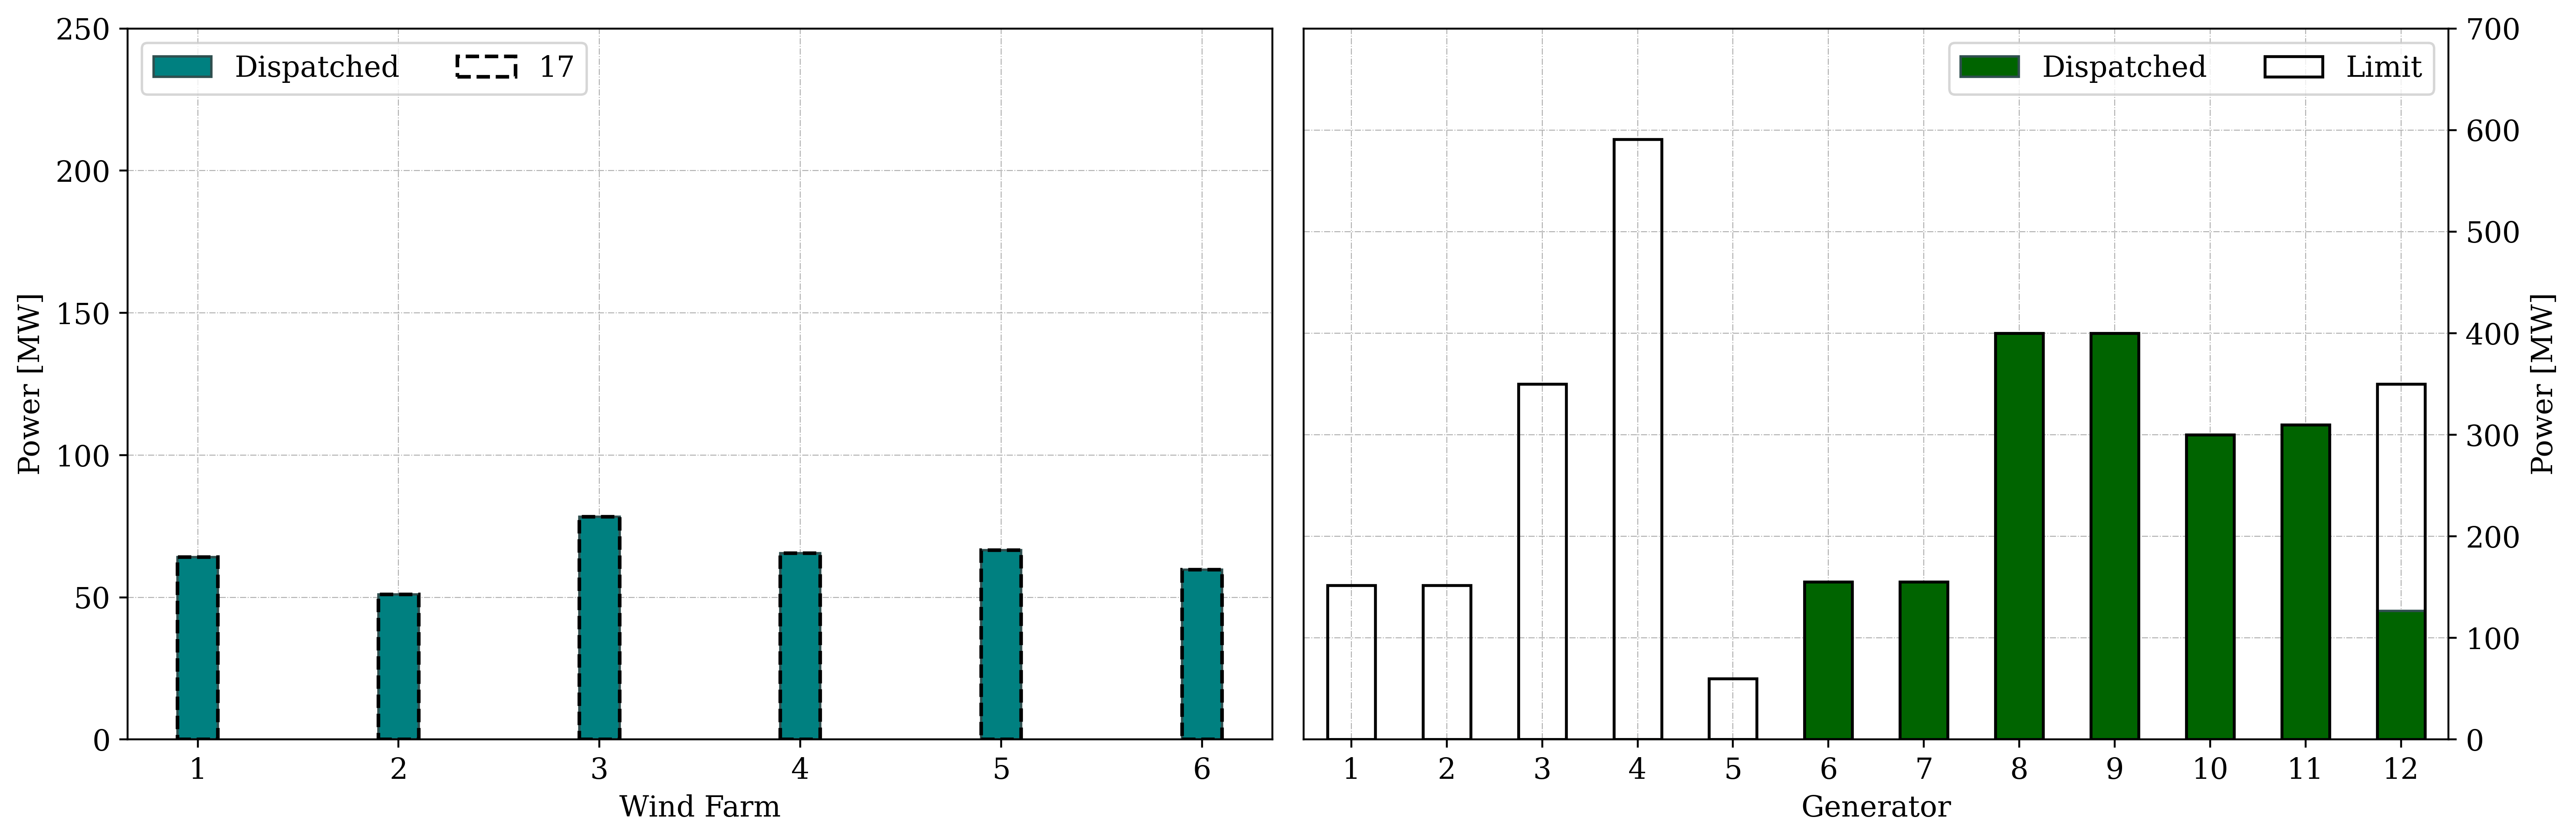

In [79]:
fig, ax = plt.subplots(1,2,sharey=False,figsize=( 15 , 5 ), dpi=400) # Create the figure

wind_data_formatted = wind_data.iloc[t, :].reset_index(drop=True).to_frame().rename(columns={0: 'Expected Production'})

#========== Plot wind farm results ==========
(generator_outputs.loc[generator_outputs.Type == 'Wind','p_G']).plot(kind='bar', ax=ax[0], color='teal', width=0.2, label='Dispatched', edgecolor='darkslategrey')
wind_data_formatted.plot(kind='bar', ax=ax[0], width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=1.5, label='Expected Production')
ax[0].set_ylabel('Power [MW]')
ax[0].set_xlabel('Wind Farm')
ax[0].set_xticks(ticks = np.arange(0, GW), labels = np.arange(1, GW + 1), fontsize=12, rotation = 0)
ax[0].legend(loc='upper left', ncol=2, fontsize=12)
ax[0].set_ylim([0,250])

#========== Plot conventional generator results ==========
(generator_outputs.loc[generator_outputs.Type == 'Conventional','p_G']).plot(kind='bar', ax=ax[1], color='darkgreen', label='Dispatched', edgecolor='darkslategrey')
gen_data['P max MW'].plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Generator')
ax[1].set_xticks(ticks = np.arange(0, GC), labels = np.arange(1, GC + 1), fontsize=12, rotation = 0)
ax[1].legend(loc='upper right', ncol=2, fontsize=12)
ax[1].set_ylim([0,700])

for k in range(2):
    ax[k].spines[['right', 'top']].set_visible(True)
    ax[k].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/task_1_results_gen_dispatch.png',bbox_inches='tight')
plt.show()

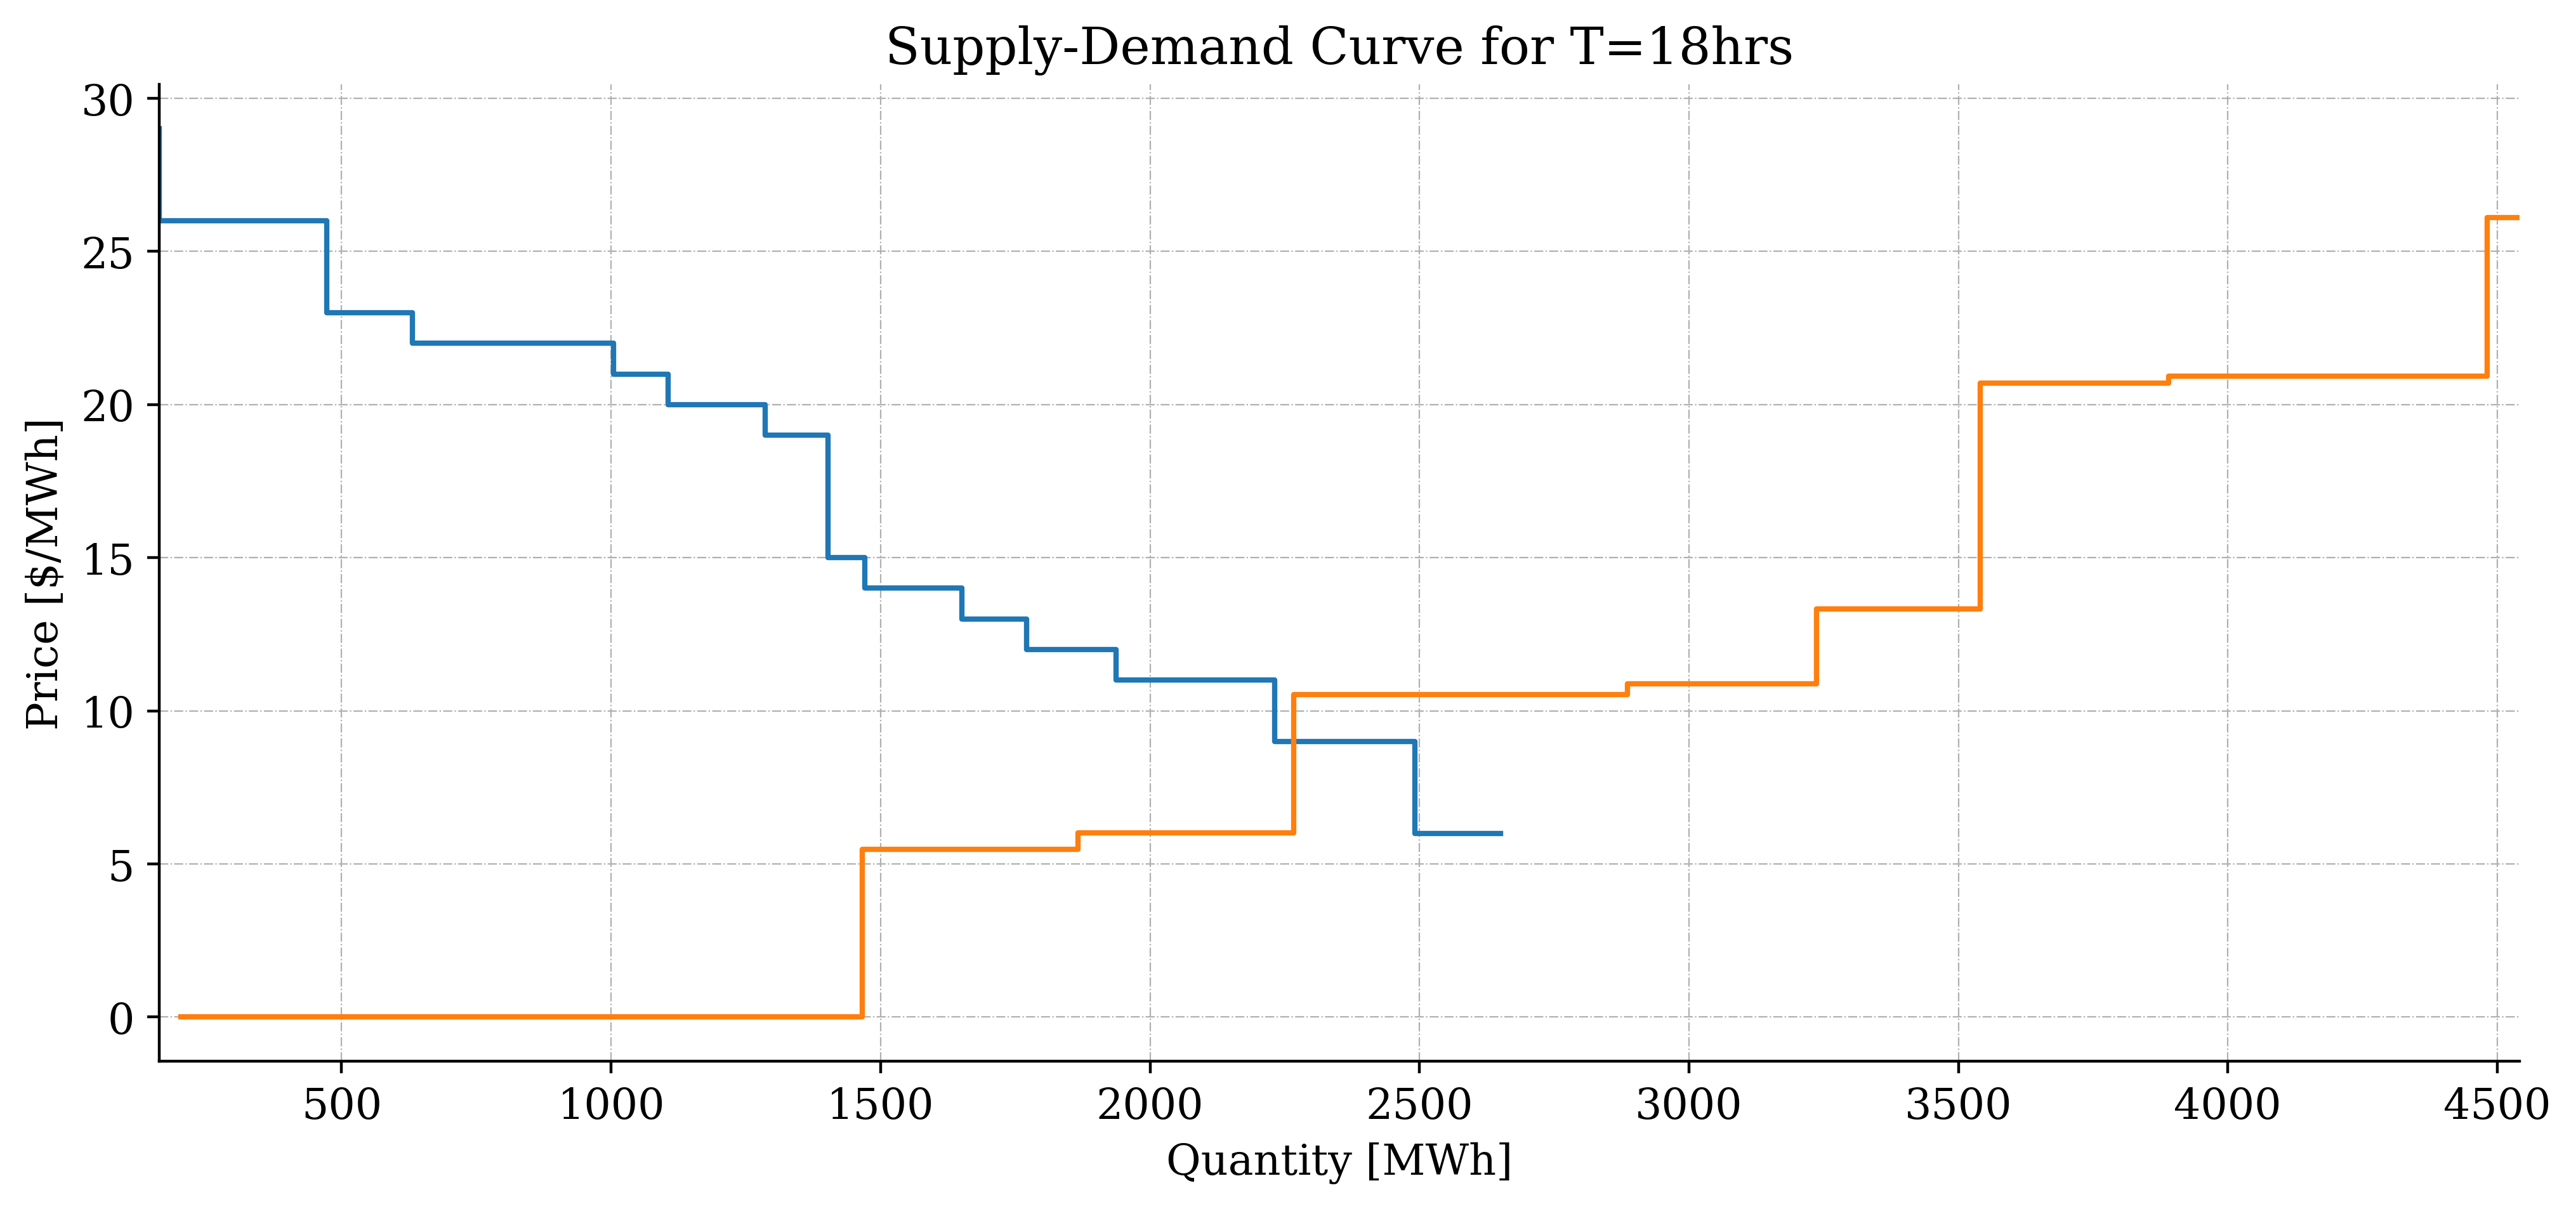

Lambda:  10.89


In [89]:
#=================== Demand Data ==========================
bid_pairs = pd.DataFrame() # pairing load demand and bid price 

# Filter the zeroes out using the mask
# mask = load != 0
# load = load[mask]

bid_pairs["load"] = load[load != 0]
bid_pairs["bid"] = bid_prices
sorted_bids = bid_pairs.sort_values(by='bid', ascending=False) # sort the prices from high to low
sorted_bids['cummulative_load'] = sorted_bids['load'].cumsum() # plotting SD-curves requires cummulative quantity values for the x-axis

#=================== Supply Data ==========================
offer_pairs = pd.DataFrame() # pairing gen. max capacity and offer price 
offer_pairs["capacity"] = gen_data['P max MW']
offer_pairs["offer"] = gen_costs['C ($/MWh)']
wind = wind_data.iloc[0,:].values
wind_final = pd.DataFrame(wind, columns=['capacity'])
wind_final["offer"] = 0
offer_pairs = pd.concat([offer_pairs, wind_final], axis = 0, ignore_index=False).reset_index(drop=True)
sorted_offers = offer_pairs.sort_values(by='offer', ascending=True) # sort the prices from low to high
sorted_offers['cummulative_capacity'] = sorted_offers['capacity'].cumsum() # plotting SD-curves requires cummulative quantity values for the x-axis

#============== Plotting supply-demand curves =============
fig, ax = plt.subplots(figsize=( 12 , 5 ), dpi=400) # Create the figure
plt.step(sorted_bids['cummulative_load'], sorted_bids["bid"])
plt.step(sorted_offers['cummulative_capacity'], sorted_offers['offer'])
plt.xlabel('Quantity [MWh]')
plt.ylabel('Price [$/MWh]')
plt.title(f'Supply-Demand Curve for T={t+1}hrs')
plt.margins(x=0)
plt.show()
print("Lambda: ", m.Pi[0])